# Efficient data generation and handling with do-mpc

We start by importing basic modules and **do-mpc**.

In [24]:
import numpy as np
import sys
from casadi import *
import os
import time

# Add do_mpc to path. This is not necessary if it was installed via pip
sys.path.append('../../../')

# Import do_mpc package:
import do_mpc

import matplotlib.pyplot as plt

import pandas as pd

## Toy example


**Step 1:** Create the ``sampling_plan`` with the ``SamplingPlanner``.

<img src="./figures/sampling_concept_01_planner.pdf" width="60%">


The planner is initiated and we set some (optional) parameters.

In [12]:
sp = do_mpc.sampling.SamplingPlanner()
sp.set_param(overwrite = True)
# This generates the directory, if it does not exist already.
sp.data_dir = './sampling_test/'

We then introduce new variables to the ``SamplingPlanner`` which will later jointly define a sampling case. Think of header rows in a table (see figure above). 

These variables can themselves be sampled from a generating function or we add user defined cases one by one. If we want to sample variables to define the sampling case, we need to pass a sample generating function as shown below:

In [13]:
sp.set_sampling_var('alpha', np.random.randn)
sp.set_sampling_var('beta', lambda: np.random.randint(0,5))

In this example we have two variables ``alpha`` and ``beta``. We have:

$$
\alpha \sim \mathcal{N}(\mu,\sigma)
$$

and 

$$
\beta\sim \mathcal{U}([0,5])
$$

Having defined generating functions for **all of our variables**, we can now generate a sampling plan with an arbitrary amount of cases:

```python
SamplingPlanner.gen_sampling_plan(n_samples)
```

In [14]:
plan = sp.gen_sampling_plan(n_samples=10)

We can inspect the plan conveniently by converting it to a pandas ``DataFrame``. Natively, the plan is a list of dictionaries.

In [15]:
pd.DataFrame(plan)

alpha  beta   id
0 -0.667866     3  000
1  1.410224     0  001
2 -0.930048     4  002
3  0.287963     3  003
4 -0.364391     3  004
5  0.408392     3  005
6  0.663371     4  006
7 -0.485988     1  007
8  0.181226     2  008
9  0.868655     1  009

If we do not wish to automatically generate a sampling plan, we can also add sampling cases one by one with:

In [19]:
plan = sp.add_sampling_case(alpha=1, beta=-0.5)
print(plan[-1])

{'alpha': 1, 'beta': -0.5, 'id': '012'}


Typically, we finish the process of generating the sampling plan by saving it to the disc. This is simply done with:
```python
sp.export(sampling_plan_name)
```
The save directory was already set with ``sp.data_dir = ...``.

**Step 2:** Create the ``Sampler`` object by providing the ``sampling_plan``:

<img src="./figures/sampling_concept_02_sampler.pdf" width="60%">

In [31]:
sampler = do_mpc.sampling.Sampler(plan)
sampler.set_param(overwrite = True)

Most important settting of the sampler is the ``sample_function``. This function takes as arguments previously the defined ``sampling_var`` (from the configuration of the ``SamplingPlanner``).

It this example, we create a dummy sampling generating function, where:

$$
f(\alpha,\beta) = \alpha\cdot\beta
$$

In [32]:
def sample_function(alpha, beta):
    time.sleep(0.1)
    return alpha*beta

sampler.set_sample_function(sample_function)

Before we sample, we want to set the directory for the created files and a name:

In [33]:
sampler.data_dir = './sampling_test/'
sampler.set_param(sample_name = 'dummy_sample')

Now we can actually create all the samples:

In [34]:
sampler.sample_data()

Progress: |██████████████████████████████████████████████████| 100.0% Complete


The sampler will now create the sampling results as a new file for each result and store them in a subfolder with the same name as the ``sampling_plan``:

In [35]:
ls = os.listdir('./sampling_test/')
ls.sort()
ls

['dummy_sample_000.pkl',
 'dummy_sample_001.pkl',
 'dummy_sample_002.pkl',
 'dummy_sample_003.pkl',
 'dummy_sample_004.pkl',
 'dummy_sample_005.pkl',
 'dummy_sample_006.pkl',
 'dummy_sample_007.pkl',
 'dummy_sample_008.pkl',
 'dummy_sample_009.pkl',
 'dummy_sample_010.pkl',
 'dummy_sample_011.pkl',
 'dummy_sample_012.pkl']

**Step 3:** Process data in the data handler class. 

<img src="./figures/sampling_concept_03_handler.pdf" width="60%">

The first step is to initiate the class with the ``sampling_plan``:

In [36]:
dh = do_mpc.sampling.DataHandler(plan)

We then need to point out where the data is stored and how the samples are called:

In [37]:
dh.data_dir = './sampling_test/'
dh.set_param(sample_name = 'dummy_sample')

Next, we define the post-processing functions. For this toy example we do some "dummy" post-processing and request to compute two results:

In [38]:
dh.set_post_processing('res_1', lambda x: x)
dh.set_post_processing('res_2', lambda x: x**2)

The interface of ``DataHandler.set_post_processing`` requires a name that we will see again later and a function that processes the output of the previously defined ``sample_function``.

We can now obtain **obtain processed data** from the ``DataHandler`` in two ways. Note that we convert the returned list of dictionaries directly to a ``DataFrame`` for a better visualization.

**1. Indexing**:

In [41]:
pd.DataFrame(dh[:3])

alpha  beta   id     res_1      res_2
0 -0.667866     3  000 -2.003599   4.014408
1  1.410224     0  001  0.000000   0.000000
2 -0.930048     4  002 -3.720191  13.839823

Or we use a more complex filter with the ``DataHandler.filter`` method. This method requires either an input or an output filter in the form of a function.

Let's retrieve all samples, where $\alpha < 0$:

In [42]:
pd.DataFrame(dh.filter(input_filter = lambda alpha: alpha<0))

alpha  beta   id     res_1      res_2
0 -0.667866     3  000 -2.003599   4.014408
1 -0.930048     4  002 -3.720191  13.839823
2 -0.364391     3  004 -1.093174   1.195029
3 -0.485988     1  007 -0.485988   0.236184

Or we can filter by outputs, e.g. with: 

In [43]:
pd.DataFrame(dh.filter(output_filter = lambda res_2: res_2>10))

alpha  beta   id     res_1      res_2
0 -0.930048     4  002 -3.720191  13.839823

# Sampling closed-loop trajectories

A more reasonable use-case in the scope of **do-mpc** is to sample closed-loop trajectories of a dynamical system with a (MPC) controller. 

The approach is almost identical to our toy example above. The main difference lies in the ``sample_function`` that is passed to the ``Sampler`` and the ``post_processing`` in the ``DataHandler``.

In the presented example, we will sample the oscillating mass system which is part of the do-mpc example library. 

In [44]:
sys.path.append('../../../examples/oscillating_masses_discrete/')
from template_model import template_model
from template_mpc import template_mpc
from template_simulator import template_simulator

**Step 1:** Create the ``sampling plan`` with the ``SamplingPlanner``

We want to generate various closed-loop trajectories of the system starting from random initial states, hence we design the ``SamplingPlanner`` as follows:

In [46]:
# Initialize sampling planner
sp = do_mpc.sampling.SamplingPlanner()
sp.set_param(overwrite=True)

# Sample random feasible initial states
def gen_initial_states():
    
    x0 = np.random.uniform(-3*np.ones((4,1)),3*np.ones((4,1)))
    
    return x0

# Add sampling variable including the corresponding evaluation function
sp.set_sampling_var('X0', gen_initial_states)

This implementation is sufficient to generate the sampling plan:

In [77]:
plan = sp.gen_sampling_plan(n_samples=9)

Since we want to run the system in the closed-loop in our sample function, we need to load the corresponding configuration:

In [78]:
model = template_model()
mpc = template_mpc(model)
estimator = do_mpc.estimator.StateFeedback(model)
simulator = template_simulator(model)

We can now define the sampling function:

In [79]:
def run_closed_loop(X0):
    mpc.reset_history()
    simulator.reset_history()
    estimator.reset_history()

    # set initial values and guess
    x0 = X0
    mpc.x0 = x0
    simulator.x0 = x0
    estimator.x0 = x0

    mpc.set_initial_guess()

    # run the closed loop for 150 steps
    for k in range(100):
        u0 = mpc.make_step(x0)
        y_next = simulator.make_step(u0)
        x0 = estimator.make_step(y_next)

    # we return the complete data structure that we have obtained during the closed-loop run
    return mpc.data

Now we have all the ingredients to make our sampler:

In [80]:
# Initialize sampler with generated plan
sampler = do_mpc.sampling.Sampler(plan)
# Set directory to store the results:
sampler.data_dir = './sampling_closed_loop/'
sampler.set_param(overwrite=True)

# Set the sampling function
sampler.set_sample_function(run_closed_loop)

# Generate the data
sampler.sample_data()

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

   1  5.8995948e+01 1.27e+00 2.14e+00  -1.0 2.13e+00    -  2.36e-01 2.05e-01f  1
   2  5.4063232e+01 8.04e-01 2.37e+00  -1.0 2.61e+00    -  8.00e-01 3.65e-01f  1
   3  5.9881003e+01 4.44e-16 3.66e-02  -1.0 1.18e+00    -  9.79e-01 1.00e+00h  1
   4  5.9386828e+01 4.44e-16 3.95e-15  -1.7 4.44e-02    -  1.00e+00 1.00e+00f  1
   5  5.9224509e+01 4.44e-16 2.64e-04  -3.8 1.65e-02    -  9.93e-01 1.00e+00f  1
   6  5.9221614e+01 4.44e-16 4.86e-15  -5.7 4.08e-04    -  1.00e+00 1.00e+00f  1
   7  5.9221601e+01 4.44e-16 5.49e-15  -8.6 1.31e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   5.9221600881807319e+01    5.9221600881807319e+01
Dual infeasibility......:   5.4884208148644532e-15    5.4884208148644532e-15
Constraint violation....:   4.4408920985006262e-16    4.4408920985006262e-16
Complementarity.........:   2.5096679640067964e-09    2.5096679640067964e-09
Overall NLP error.......

   nlp_jac_g  |  22.00us (  2.20us)  23.60us (  2.36us)        10
       total  |   4.67ms (  4.67ms)   4.64ms (  4.64ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality c

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.4145494e-01 2.00e-01 3.50e-05  -1.0 0.00e+00    -  0.00e+00 0.

   2  4.5626545e-04 8.67e-19 4.25e-17  -2.5 2.45e-03    -  1.00e+00 1.00e+00f  1
   3  4.5286969e-04 2.60e-18 8.67e-18  -3.8 2.61e-03    -  1.00e+00 1.00e+00f  1
   4  4.5286415e-04 8.67e-19 5.59e-18  -5.7 1.96e-04    -  1.00e+00 1.00e+00f  1
   5  4.5286415e-04 2.60e-18 5.20e-18  -8.6 1.17e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   4.5286415117000802e-04    4.5286415117000802e-04
Dual infeasibility......:   5.2041704279304213e-18    5.2041704279304213e-18
Constraint violation....:   2.6020852139652106e-18    2.6020852139652106e-18
Complementarity.........:   2.5103963996904368e-09    2.5103963996904368e-09
Overall NLP error.......:   2.5103963996904368e-09    2.5103963996904368e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequal

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.1647055e+01 1.75e+00 2.95e+00  -1.0 0.00e+00    -  0.00e+00 0.

   1  3.3534491e+00 1.39e-16 7.56e-01  -1.0 6.50e-01    -  4.79e-01 1.00e+00f  1
   2  2.8820787e+00 1.11e-16 1.55e-02  -1.0 3.88e-01    -  9.88e-01 1.00e+00f  1
   3  2.7706607e+00 1.11e-16 4.45e-03  -1.7 1.62e-01    -  9.53e-01 1.00e+00f  1
   4  2.6708341e+00 1.11e-16 1.10e-15  -2.5 1.50e-01    -  1.00e+00 1.00e+00f  1
   5  2.6422556e+00 1.11e-16 6.23e-04  -3.8 6.72e-02    -  9.91e-01 1.00e+00f  1
   6  2.6395656e+00 1.11e-16 9.99e-16  -3.8 3.60e-02    -  1.00e+00 1.00e+00f  1
   7  2.6388044e+00 1.11e-16 1.72e-04  -5.7 2.25e-02    -  9.88e-01 9.80e-01f  1
   8  2.6387450e+00 5.55e-17 5.92e-16  -5.7 1.11e-02    -  1.00e+00 1.00e+00f  1
   9  2.6387402e+00 5.55e-17 7.31e-16  -5.7 4.08e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.6387345e+00 1.11e-16 2.71e-08  -8.6 1.17e-03    -  1.00e+00 1.00e+00f  1
  11  2.6387345e+00 1.11e-16 9.87e-16  -8.6 8.34e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 1

   5  2.2174533e-02 6.94e-18 8.33e-17  -8.6 2.31e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   2.2174532815338602e-02    2.2174532815338602e-02
Dual infeasibility......:   8.3266726846886741e-17    8.3266726846886741e-17
Constraint violation....:   6.9388939039072284e-18    6.9388939039072284e-18
Complementarity.........:   2.5161817221790039e-09    2.5161817221790039e-09
Overall NLP error.......:   2.5161817221790039e-09    2.5161817221790039e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o fun


EXIT: Optimal Solution Found.
           S  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  10.00us (  1.67us)  10.94us (  1.82us)         6
       nlp_g  |  17.00us (  2.83us)  17.39us (  2.90us)         6
    nlp_grad  |  10.00us ( 10.00us)   7.14us (  7.14us)         1
  nlp_grad_f  |  16.00us (  2.29us)  14.79us (  2.11us)         7
  nlp_hess_l  |  10.00us (  2.00us)   8.76us (  1.75us)         5
   nlp_jac_g  |  20.00us (  2.86us)  19.54us (  2.79us)         7
       total  |  19.46ms ( 19.46ms)  29.11ms ( 29.11ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only 

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.6461772e-08 7.45e-05 1.27e-08  -1.0 0.00e+00    -  0.00e+00 0.

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.9978635e+01 1.13e+00 3.66e+00  -1.0 0.00e+00    -  0.00e+00 0.

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.7231571e+01 1.14e+00 9.85e-01  -1.0 0.00e+00    -  0.00e+00 0.

   6  1.6247678e+00 5.55e-17 3.61e-16  -3.8 2.03e-02    -  1.00e+00 1.00e+00f  1
   7  1.6239568e+00 8.33e-17 1.89e-05  -5.7 6.89e-03    -  9.96e-01 1.00e+00f  1
   8  1.6239237e+00 1.11e-16 4.55e-16  -5.7 4.82e-04    -  1.00e+00 1.00e+00f  1
   9  1.6239181e+00 5.55e-17 8.82e-16  -8.6 3.00e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   1.6239181250503583e+00    1.6239181250503583e+00
Dual infeasibility......:   8.8183567817240742e-16    8.8183567817240742e-16
Constraint violation....:   5.5511151231257827e-17    5.5511151231257827e-17
Complementarity.........:   3.2930564984129174e-09    3.2930564984129174e-09
Overall NLP error.......:   3.2930564984129174e-09    3.2930564984129174e-09


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 10
Number of ineq

   2  1.3251389e-03 1.73e-18 2.52e-17  -2.5 4.88e-03    -  1.00e+00 1.00e+00f  1
   3  1.3189406e-03 3.47e-18 8.13e-18  -3.8 1.84e-03    -  1.00e+00 1.00e+00f  1
   4  1.3189375e-03 2.60e-18 1.96e-17  -5.7 6.35e-05    -  1.00e+00 1.00e+00h  1
   5  1.3189375e-03 3.47e-18 1.37e-17  -8.6 6.86e-07    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   1.3189374782698220e-03    1.3189374782698220e-03
Dual infeasibility......:   1.3679635037716154e-17    1.3679635037716154e-17
Constraint violation....:   3.4694469519536142e-18    3.4694469519536142e-18
Complementarity.........:   2.5085321074043928e-09    2.5085321074043928e-09
Overall NLP error.......:   2.5085321074043928e-09    2.5085321074043928e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequal

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.2986833e-06 6.85e-04 8.48e-08  -1.0 0.00e+00    -  0.00e+00 0.

   7  2.5699198e+01 4.44e-16 1.46e-05  -5.7 7.36e-03    -  9.98e-01 1.00e+00f  1
   8  2.5699182e+01 4.44e-16 3.55e-15  -5.7 1.44e-03    -  1.00e+00 1.00e+00f  1
   9  2.5699172e+01 4.44e-16 2.66e-15  -8.6 9.38e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   2.5699172214924243e+01    2.5699172214924243e+01
Dual infeasibility......:   2.6645352591003757e-15    2.6645352591003757e-15
Constraint violation....:   4.4408920985006262e-16    4.4408920985006262e-16
Complementarity.........:   8.9552776003925640e-09    8.9552776003925640e-09
Overall NLP error.......:   8.9552776003925640e-09    8.9552776003925640e-09


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 10
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian

   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0413475e+00 3.58e-01 2.17e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.0125247e+00 6.94e-17 4.46e-01  -1.0 3.58e-01    -  5.53e-01 1.00e+00f  1
   2  8.4687374e-01 5.55e-17 9.46e-03  -1.0 5.43e-01    -  9.91e-01 1.00e+00f  1
   3  8.0671041e-01 5.55e-17 5.00e-16  -1.7 6.61e-02    -  1.00e+00 1.00e+00f  1
   4  7.7959607e-01 5.55e-17 5.06e-16  -2.5 8.54e-02    -  1.00e+00 1.00e+00f  1
   5  7.7009222e-01 5.55e-17 5.79e-16  -3.8 5.46e-02    -  1.00e+00 1.00e+00f  1
   6  7.6783274e-01 8.33e-17 3.97e-16  -3.8 1.88e-02    -  1.00e+00 1.00e+00f  1
   7  7.6745766e-01 5.55e-17 5.55e-16  -5.7 3.37e-03    -  1.00e+00 1.00e+00f  1
   8  7.6744809e-01 5.55e-17 4.73e-16  -8.6 1.01e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 8

                               

   2  8.5845072e-04 2.60e-18 2.08e-17  -2.5 3.51e-03    -  1.00e+00 1.00e+00f  1
   3  8.5147650e-04 1.73e-18 2.09e-17  -3.8 3.48e-03    -  1.00e+00 1.00e+00f  1
   4  8.5146589e-04 8.67e-19 1.39e-17  -5.7 2.60e-04    -  1.00e+00 1.00e+00f  1
   5  8.5146589e-04 1.73e-18 1.21e-17  -8.6 1.69e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   8.5146589413398282e-04    8.5146589413398282e-04
Dual infeasibility......:   1.2143064331837650e-17    1.2143064331837650e-17
Constraint violation....:   1.7347234759768071e-18    1.7347234759768071e-18
Complementarity.........:   2.5125146541557296e-09    2.5125146541557296e-09
Overall NLP error.......:   2.5125146541557296e-09    2.5125146541557296e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequal

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.7698689e-09 1.63e-05 1.78e-09  -1.0 0.00e+00    -  0.00e+00 0.

   6  9.1976274e-01 5.55e-17 2.93e-04  -5.7 1.64e-02    -  9.75e-01 1.00e+00f  1
   7  9.1965144e-01 5.55e-17 7.77e-16  -5.7 7.44e-03    -  1.00e+00 1.00e+00f  1
   8  9.1962262e-01 4.86e-17 4.44e-16  -5.7 2.38e-03    -  1.00e+00 1.00e+00f  1
   9  9.1961756e-01 8.33e-17 4.16e-16  -8.6 4.44e-04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  9.1961744e-01 1.11e-16 4.99e-16  -8.6 1.10e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   9.1961743939919549e-01    9.1961743939919549e-01
Dual infeasibility......:   4.9867398998449252e-16    4.9867398998449252e-16
Constraint violation....:   1.1102230246251565e-16    1.1102230246251565e-16
Complementarity.........:   2.5783736324277692e-09    2.5783736324277692e-09
Overall NLP error.......:   2.5783736324277692e-09    2.5783736324277692e-09


Number of objective funct

   5  6.7478289e-03 3.47e-18 3.47e-17  -8.6 5.55e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   6.7478288609347237e-03    6.7478288609347237e-03
Dual infeasibility......:   3.4694469519536142e-17    3.4694469519536142e-17
Constraint violation....:   3.4694469519536142e-18    3.4694469519536142e-18
Complementarity.........:   2.5313324473060793e-09    2.5313324473060793e-09
Overall NLP error.......:   2.5313324473060793e-09    2.5313324473060793e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o fun

   0  1.5503227e-05 9.25e-04 1.61e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.3991821e-05 6.51e-19 2.54e-07  -1.0 1.02e-03    -  1.00e+00 1.00e+00h  1
   2  1.2670847e-05 2.17e-19 2.60e-17  -2.5 4.26e-04    -  1.00e+00 1.00e+00f  1
   3  1.2617052e-05 3.25e-19 1.73e-18  -3.8 2.33e-04    -  1.00e+00 1.00e+00f  1
   4  1.2617004e-05 2.17e-19 1.39e-18  -5.7 1.80e-05    -  1.00e+00 1.00e+00h  1
   5  1.2617004e-05 2.17e-19 1.36e-18  -8.6 8.97e-08    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   1.2617003564156202e-05    1.2617003564156202e-05
Dual infeasibility......:   1.3623995560993387e-18    1.3623995560993387e-18
Constraint violation....:   2.1684043449710089e-19    2.1684043449710089e-19
Complementarity.........:   2.5062353761830804e-09    2.5062353761830804e-09
Overall NLP error.......:   2.5062353761830804e-09    2.5062353761830804e-09


Number of objective functi

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.0110016e-08 4.55e-05 1.25e-09  -1.0 0.00e+00    -  0.00e+00 0.

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.7226496e+01 2.08e+00 1.95e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  8.7819321e+01 5.66e-01 4.14e+00  -1.0 2.75e+00    -  1.75e-01 

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.8556276e+01 9.78e-01 1.42e+00  -1.0 0.00e+00    -  0.00e+00 0.

   9  5.0764784e+00 1.11e-16 9.95e-16  -5.7 7.99e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.0764706e+00 1.11e-16 9.92e-16  -5.7 3.68e-03    -  1.00e+00 1.00e+00f  1
  11  5.0764610e+00 1.11e-16 9.02e-06  -8.6 2.17e-03    -  9.99e-01 9.87e-01f  1
  12  5.0764604e+00 2.22e-16 1.22e-15  -8.6 1.09e-03    -  1.00e+00 1.00e+00f  1
  13  5.0764603e+00 2.22e-16 1.89e-15  -8.6 5.16e-04    -  1.00e+00 1.00e+00f  1
  14  5.0764603e+00 1.11e-16 2.66e-15  -8.6 2.20e-04    -  1.00e+00 1.00e+00h  1
  15  5.0764603e+00 1.11e-16 1.00e-15  -9.0 6.93e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:   5.0764603128576296e+00    5.0764603128576296e+00
Dual infeasibility......:   1.0026164771312264e-15    1.0026164771312264e-15
Constraint violation....:   1.1102230246251565e-16    1.1102230246251565e-16
Complementarity....

   5  1.5788207e-02 1.04e-17 4.16e-17  -8.6 2.85e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   1.5788207298705847e-02    1.5788207298705847e-02
Dual infeasibility......:   4.1633363423443370e-17    4.1633363423443370e-17
Constraint violation....:   1.0408340855860843e-17    1.0408340855860843e-17
Complementarity.........:   2.5181255006778560e-09    2.5181255006778560e-09
Overall NLP error.......:   2.5181255006778560e-09    2.5181255006778560e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o fun

   2  1.7476013e-05 2.17e-19 2.34e-17  -2.5 4.90e-04    -  1.00e+00 1.00e+00f  1
   3  1.7398942e-05 2.17e-19 2.01e-18  -3.8 3.00e-04    -  1.00e+00 1.00e+00f  1
   4  1.7398865e-05 2.17e-19 2.08e-18  -5.7 2.30e-05    -  1.00e+00 1.00e+00h  1
   5  1.7398865e-05 3.25e-19 1.95e-18  -8.6 1.11e-07    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   1.7398864509354656e-05    1.7398864509354656e-05
Dual infeasibility......:   1.9515639104739080e-18    1.9515639104739080e-18
Constraint violation....:   3.2526065174565133e-19    3.2526065174565133e-19
Complementarity.........:   2.5063144901916703e-09    2.5063144901916703e-09
Overall NLP error.......:   2.5063144901916703e-09    2.5063144901916703e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequal

   7  6.6132206e+01 4.44e-16 4.83e-15  -5.7 3.01e-03    -  1.00e+00 1.00e+00f  1
   8  6.6132185e+01 4.44e-16 3.11e-15  -8.6 5.05e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   6.6132185407710054e+01    6.6132185407710054e+01
Dual infeasibility......:   3.1086244689504383e-15    3.1086244689504383e-15
Constraint violation....:   4.4408920985006262e-16    4.4408920985006262e-16
Complementarity.........:   4.4257769473981574e-09    4.4257769473981574e-09
Overall NLP error.......:   4.4257769473981574e-09    4.4257769473981574e-09


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 9
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 9
Number of inequality constraint Jacobian evaluations = 0
Number o

   3  1.7253957e+01 2.22e-16 1.87e-02  -1.7 6.33e-02    -  8.58e-01 1.00e+00f  1
   4  1.7121618e+01 2.22e-16 2.33e-15  -2.5 9.11e-02    -  1.00e+00 1.00e+00f  1
   5  1.7102555e+01 2.22e-16 1.22e-15  -3.8 2.67e-02    -  1.00e+00 1.00e+00f  1
   6  1.7101455e+01 2.22e-16 1.95e-15  -5.7 8.53e-03    -  1.00e+00 1.00e+00f  1
   7  1.7101449e+01 2.22e-16 4.00e-15  -5.7 7.87e-04    -  1.00e+00 1.00e+00f  1
   8  1.7101439e+01 2.22e-16 1.62e-15  -8.6 1.67e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   1.7101439368931665e+01    1.7101439368931665e+01
Dual infeasibility......:   1.6195333214275471e-15    1.6195333214275471e-15
Constraint violation....:   2.2204460492503131e-16    2.2204460492503131e-16
Complementarity.........:   2.9885852386924283e-09    2.9885852386924283e-09
Overall NLP error.......:   2.9885852386924283e-09    2.9885852386924283e-09


Number of objective functi

                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.9091311e-01 2.84e-01 2.16e-05  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  6.2437382e-01 5.55e-17 3.26e-01  -1.0 2.84e-01    -  6.46e-01 1.00e+00h  1
   2  4.6876875e-01 5.55e-17 4.44e-16  -1.0 2.88e-01    -  1.00e+00 1.00e+00f  1
   3  4.5163020e-01 2.78e-17 6.65e-03  -2.5 4.43e-02    -  9.53e-01 1.00e+00f  1
   4  4.4918139e-01 2.78e-17 2.72e-03  -3.8 4.66e-02    -  9.67e-01 1.00e+00f  1
 

   5  6.3997583e-04 1.73e-18 1.04e-17  -8.6 8.41e-07    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   6.3997582859131750e-04    6.3997582859131750e-04
Dual infeasibility......:   1.0408340855860843e-17    1.0408340855860843e-17
Constraint violation....:   1.7347234759768071e-18    1.7347234759768071e-18
Complementarity.........:   2.5090649772805708e-09    2.5090649772805708e-09
Overall NLP error.......:   2.5090649772805708e-09    2.5090649772805708e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o fun

   2  2.0210315e-06 8.13e-20 1.99e-17  -2.5 1.61e-04    -  1.00e+00 1.00e+00f  1
   3  2.0081845e-06 1.08e-19 5.96e-19  -3.8 1.58e-04    -  1.00e+00 1.00e+00f  1
   4  2.0081645e-06 1.08e-19 4.34e-19  -5.7 1.20e-05    -  1.00e+00 1.00e+00h  1
   5  2.0081645e-06 8.13e-20 7.92e-19  -8.6 6.76e-08    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   2.0081644771543467e-06    2.0081644771543467e-06
Dual infeasibility......:   7.9239932215639797e-19    7.9239932215639797e-19
Constraint violation....:   8.1315162936412833e-20    8.1315162936412833e-20
Complementarity.........:   2.5061531115122157e-09    2.5061531115122157e-09
Overall NLP error.......:   2.5061531115122157e-09    2.5061531115122157e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequal

   1  5.3398934e+01 8.88e-16 2.23e+00  -1.0 1.81e+00    -  3.56e-01 1.00e+00f  1
   2  5.1763577e+01 4.44e-16 5.19e-01  -1.0 1.38e+00    -  9.16e-01 6.27e-01f  1
   3  5.1270803e+01 8.88e-16 6.22e-15  -1.7 6.53e-02    -  1.00e+00 1.00e+00f  1
   4  5.1160167e+01 4.44e-16 7.11e-15  -2.5 3.55e-02    -  1.00e+00 1.00e+00f  1
   5  5.1138356e+01 4.44e-16 4.86e-15  -3.8 5.66e-03    -  1.00e+00 1.00e+00f  1
   6  5.1137214e+01 4.44e-16 2.20e-15  -5.7 2.47e-04    -  1.00e+00 1.00e+00f  1
   7  5.1137201e+01 8.88e-16 4.44e-15  -8.6 2.49e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   5.1137200600495419e+01    5.1137200600495419e+01
Dual infeasibility......:   4.4408920985006262e-15    4.4408920985006262e-15
Constraint violation....:   8.8817841970012523e-16    8.8817841970012523e-16
Complementarity.........:   2.5157059552310167e-09    2.5157059552310167e-09
Overall NLP error.......

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

   1  2.4847888e-04 8.67e-19 3.41e-06  -1.0 4.60e-03    -  1.00e+00 1.00e+00h  1
   2  2.2714652e-04 8.67e-19 2.26e-17  -2.5 1.70e-03    -  1.00e+00 1.00e+00f  1
   3  2.2596755e-04 1.73e-18 6.94e-18  -3.8 1.39e-03    -  1.00e+00 1.00e+00f  1
   4  2.2596600e-04 1.73e-18 5.79e-18  -5.7 1.06e-04    -  1.00e+00 1.00e+00h  1
   5  2.2596600e-04 1.73e-18 1.14e-17  -8.6 5.58e-07    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   2.2596600010149474e-04    2.2596600010149474e-04
Dual infeasibility......:   1.1388463854952475e-17    1.1388463854952475e-17
Constraint violation....:   1.7347234759768071e-18    1.7347234759768071e-18
Complementarity.........:   2.5079893615949624e-09    2.5079893615949624e-09
Overall NLP error.......:   2.5079893615949624e-09    2.5079893615949624e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations          

   5  1.0999183e-06 5.42e-20 8.67e-19  -8.6 2.19e-08    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   1.0999182727287832e-06    1.0999182727287832e-06
Dual infeasibility......:   8.6736173798840355e-19    8.6736173798840355e-19
Constraint violation....:   5.4210108624275222e-20    5.4210108624275222e-20
Complementarity.........:   2.5059843272217788e-09    2.5059843272217788e-09
Overall NLP error.......:   2.5059843272217788e-09    2.5059843272217788e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o fun

Number of equality constraint evaluations            = 13
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 13
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 12
Total CPU secs in IPOPT (w/o function evaluations)   =      0.005
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
           S  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  17.00us (  1.31us)  19.12us (  1.47us)        13
       nlp_g  |  32.00us (  2.46us)  31.07us (  2.39us)        13
    nlp_grad  |  25.00us ( 25.00us)  18.14us ( 18.14us)         1
  nlp_grad_f  |  24.00us (  1.71us)  23.03us (  1.65us)        14
  nlp_hess_l  |  18.00us (  1.50us)  17.31us (  1.44us)        12
   nlp_jac_g  |  28.00us (  2.00us)  31.20us (  2.23us)        14
       total  |  26.00ms ( 26.00ms)  39.51ms ( 39.51ms)         1
This is Ipopt version

   9  2.5722784e+01 3.33e-16 4.66e-15  -8.6 6.70e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   2.5722784355011949e+01    2.5722784355011949e+01
Dual infeasibility......:   4.6629367034256575e-15    4.6629367034256575e-15
Constraint violation....:   3.3306690738754696e-16    3.3306690738754696e-16
Complementarity.........:   4.2548542978297458e-09    4.2548542978297458e-09
Overall NLP error.......:   4.2548542978297458e-09    4.2548542978297458e-09


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 10
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 10
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 9
Total CPU secs in IPOPT (w/o

   1  3.6935250e+00 1.67e-16 1.24e+00  -1.0 5.56e-01    -  3.63e-01 1.00e+00f  1
   2  3.0021058e+00 1.11e-16 3.78e-02  -1.0 7.70e-01    -  9.60e-01 1.00e+00f  1
   3  2.8910814e+00 1.11e-16 8.88e-16  -1.7 8.78e-02    -  1.00e+00 1.00e+00f  1
   4  2.8088578e+00 5.55e-17 4.80e-16  -2.5 1.15e-01    -  1.00e+00 1.00e+00f  1
   5  2.7800008e+00 5.55e-17 9.93e-04  -3.8 6.98e-02    -  9.89e-01 1.00e+00f  1
   6  2.7737184e+00 1.11e-16 8.88e-16  -3.8 3.80e-02    -  1.00e+00 1.00e+00f  1
   7  2.7721974e+00 1.11e-16 1.51e-04  -5.7 2.24e-02    -  9.89e-01 1.00e+00f  1
   8  2.7719980e+00 1.11e-16 8.88e-16  -5.7 1.07e-02    -  1.00e+00 1.00e+00f  1
   9  2.7719674e+00 1.67e-16 7.04e-16  -5.7 3.25e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.7719553e+00 1.11e-16 4.27e-16  -8.6 5.55e-04    -  1.00e+00 1.00e+00f  1
  11  2.7719552e+00 1.11e-16 6.66e-16  -8.6 1.10e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 1


Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.1684347e-02 5.44e-02 3.58e-06  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.6804670e-02 1.04e-17 5.85e-04  -1.0 5.44e-02    -  9.95e-01

   5  1.7506192e-04 1.73e-18 6.29e-18  -8.6 5.37e-07    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   1.7506192413582405e-04    1.7506192413582405e-04
Dual infeasibility......:   6.2883726004159257e-18    6.2883726004159257e-18
Constraint violation....:   1.7347234759768071e-18    1.7347234759768071e-18
Complementarity.........:   2.5079092311305730e-09    2.5079092311305730e-09
Overall NLP error.......:   2.5079092311305730e-09    2.5079092311305730e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o fun

   4  2.0109728e-06 1.08e-19 7.39e-19  -5.7 9.55e-06    -  1.00e+00 1.00e+00h  1
   5  2.0109728e-06 1.08e-19 6.82e-19  -8.6 4.97e-08    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   2.0109727529226973e-06    2.0109727529226973e-06
Dual infeasibility......:   6.8154388518449141e-19    6.8154388518449141e-19
Constraint violation....:   1.0842021724855044e-19    1.0842021724855044e-19
Complementarity.........:   2.5060870007310302e-09    2.5060870007310302e-09
Overall NLP error.......:   2.5060870007310302e-09    2.5060870007310302e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 0
Number o

   5  2.6865577e+01 2.22e-16 4.22e-15  -3.8 3.73e-02    -  1.00e+00 1.00e+00f  1
   6  2.6862897e+01 2.22e-16 3.76e-15  -3.8 5.51e-03    -  1.00e+00 1.00e+00f  1
   7  2.6861809e+01 4.44e-16 2.89e-15  -5.7 4.90e-04    -  1.00e+00 1.00e+00f  1
   8  2.6861796e+01 2.22e-16 3.39e-15  -8.6 5.71e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   2.6861795596201574e+01    2.6861795596201574e+01
Dual infeasibility......:   3.3904173486066895e-15    3.3904173486066895e-15
Constraint violation....:   2.2204460492503131e-16    2.2204460492503131e-16
Complementarity.........:   2.5659746356417425e-09    2.5659746356417425e-09
Overall NLP error.......:   2.5659746356417425e-09    2.5659746356417425e-09


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 9
Number of inequal

   1  6.0309052e+00 1.67e-16 5.64e-01  -1.0 7.05e-01    -  5.59e-01 1.00e+00f  1
   2  5.5837487e+00 1.11e-16 1.79e-02  -1.0 6.15e-01    -  9.81e-01 1.00e+00f  1
   3  5.4478580e+00 1.67e-16 1.92e-02  -1.7 2.06e-01    -  8.67e-01 1.00e+00f  1
   4  5.3151833e+00 1.67e-16 1.75e-02  -2.5 2.65e-01    -  8.76e-01 1.00e+00f  1
   5  5.2763598e+00 2.22e-16 1.33e-15  -2.5 1.33e-01    -  1.00e+00 1.00e+00f  1
   6  5.2600411e+00 1.67e-16 7.61e-04  -3.8 6.79e-02    -  9.70e-01 9.90e-01f  1
   7  5.2591130e+00 2.22e-16 1.16e-15  -3.8 2.09e-02    -  1.00e+00 1.00e+00f  1
   8  5.2583322e+00 2.22e-16 4.30e-04  -5.7 1.21e-02    -  1.00e+00 9.57e-01f  1
   9  5.2582833e+00 1.67e-16 1.11e-15  -5.7 5.31e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.2582775e+00 1.67e-16 2.22e-15  -5.7 2.24e-03    -  1.00e+00 1.00e+00f  1
  11  5.2582693e+00 1.67e-16 5.42e-06  -8.6 1.07e-03    -  1.00e+00 9.95e-01f  1
  12  5.2582692e+00 2.22e-16

   5  1.0516194e-01 1.39e-17 1.19e-16  -5.7 1.01e-03    -  1.00e+00 1.00e+00f  1
   6  1.0516194e-01 2.78e-17 1.96e-16  -8.6 1.22e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:   1.0516194181916118e-01    1.0516194181916118e-01
Dual infeasibility......:   1.9591310910664411e-16    1.9591310910664411e-16
Constraint violation....:   2.7755575615628914e-17    2.7755575615628914e-17
Complementarity.........:   2.5775471715637135e-09    2.5775471715637135e-09
Overall NLP error.......:   2.5775471715637135e-09    2.5775471715637135e-09


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number o

   2  5.5272819e-05 4.34e-19 2.08e-17  -2.5 8.25e-04    -  1.00e+00 1.00e+00f  1
   3  5.4896237e-05 6.51e-19 2.60e-18  -3.8 8.68e-04    -  1.00e+00 1.00e+00f  1
   4  5.4895633e-05 6.51e-19 3.04e-18  -5.7 6.54e-05    -  1.00e+00 1.00e+00h  1
   5  5.4895633e-05 4.34e-19 2.60e-18  -8.6 3.77e-07    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   5.4895633304520712e-05    5.4895633304520712e-05
Dual infeasibility......:   2.6020852139652106e-18    2.6020852139652106e-18
Constraint violation....:   4.3368086899420177e-19    4.3368086899420177e-19
Complementarity.........:   2.5073098734853232e-09    2.5073098734853232e-09
Overall NLP error.......:   2.5073098734853232e-09    2.5073098734853232e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequal

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.9346448e-08 5.17e-05 6.61e-10  -1.0 0.00e+00    -  0.00e+00 0.

        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.7786858e+02 3.49e+00 6.23e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.5397250e+02 2.83e+00 5.06e+00  -1.0 3.49e+00    -  2.18e-01 1.89e-01f  1
   2  1.3724438e+02 1.85e+00 3.43e+00  -1.0 2.97e+00    -  6.16e-01 3.45e-01f  1
   3  1.6269104e+02 8.88e-16 3.08e-01  -1.0 1.85e+00    -  8.73e-01 1.00e+00h  1
   4  1.6263418e+02 8.88e-16 8.01e-15  -1.0 1.22e-01    -  1.00e+00 1.00e+00f  1
   5  1.6209923e+02 5.55e-16 8.03e-03  -2.5 7.46e-02    -  9.29e-01 1.00e+00f  1
   6  1.6205496e+02 8.88e-16 1.15e-14  -3.8 2.25e-02    -  1.00e+00 1.00e+00f  1
   7  1.6205387e+02 8.88e-16 6.77e-15  -5.7 1.63e-03    -  1.00e+00 1.00e+00f  1
   8  1.6205386e+02 8.88e-16 1.07e-14  -8.6 9.35e-06    -  1.00e+00 1.00e+00f 

   1  9.2580316e+01 8.88e-16 9.54e+00  -1.0 2.88e+00    -  1.06e-01 1.00e+00h  1
   2  8.7188961e+01 4.44e-16 3.74e+00  -1.0 1.61e+00    -  7.78e-01 4.94e-01f  1
   3  8.7049937e+01 8.88e-16 6.66e-15  -1.0 3.26e-01    -  1.00e+00 1.00e+00f  1
   4  8.6596466e+01 4.44e-16 9.52e-03  -2.5 4.55e-02    -  9.48e-01 1.00e+00f  1
   5  8.6557897e+01 8.88e-16 1.27e-03  -3.8 4.05e-02    -  9.51e-01 1.00e+00f  1
   6  8.6557723e+01 8.88e-16 1.02e-14  -3.8 8.26e-03    -  1.00e+00 1.00e+00f  1
   7  8.6556980e+01 4.44e-16 4.86e-15  -5.7 5.08e-04    -  1.00e+00 1.00e+00f  1
   8  8.6556971e+01 4.44e-16 7.14e-15  -8.6 6.29e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   8.6556970616583953e+01    8.6556970616583953e+01
Dual infeasibility......:   7.1393918170689028e-15    7.1393918170689028e-15
Constraint violation....:   4.4408920985006262e-16    4.4408920985006262e-16
Complementarity.....

   3  2.2832136e+01 4.44e-16 2.66e-15  -1.7 1.16e-01    -  1.00e+00 1.00e+00h  1
   4  2.2704084e+01 4.44e-16 3.22e-15  -2.5 4.63e-02    -  1.00e+00 1.00e+00f  1
   5  2.2682496e+01 2.22e-16 2.68e-15  -3.8 9.81e-03    -  1.00e+00 1.00e+00f  1
   6  2.2681407e+01 2.22e-16 5.65e-15  -5.7 5.06e-04    -  1.00e+00 1.00e+00f  1
   7  2.2681395e+01 2.22e-16 2.75e-15  -8.6 3.94e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   2.2681395229757083e+01    2.2681395229757083e+01
Dual infeasibility......:   2.7455827066858970e-15    2.7455827066858970e-15
Constraint violation....:   2.2204460492503131e-16    2.2204460492503131e-16
Complementarity.........:   2.5325833679676163e-09    2.5325833679676163e-09
Overall NLP error.......:   2.5325833679676163e-09    2.5325833679676163e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations          

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.2103401e+02 1.55e+00 3.44e+00  -1.0 0.00e+00    -  0.00e+00 0.

   9  4.4644886e+01 2.50e-16 5.33e-15  -5.7 8.23e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.4644884e+01 4.44e-16 7.99e-15  -5.7 2.26e-03    -  1.00e+00 1.00e+00f  1
  11  4.4644874e+01 2.22e-16 4.44e-15  -8.6 2.67e-04    -  1.00e+00 1.00e+00f  1
  12  4.4644874e+01 6.66e-16 4.88e-15  -8.6 2.64e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:   4.4644874462363219e+01    4.4644874462363219e+01
Dual infeasibility......:   4.8849813083506888e-15    4.8849813083506888e-15
Constraint violation....:   6.6613381477509392e-16    6.6613381477509392e-16
Complementarity.........:   2.5109374133558240e-09    2.5109374133558240e-09
Overall NLP error.......:   2.5109374133558240e-09    2.5109374133558240e-09


Number of objective function evaluations             = 13
Number of objective gradient evaluations        

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.9729747e+00 8.71e-01 6.37e-01  -1.0 0.00e+00    -  0.00e+00 0.

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.4866056e-02 5.85e-02 2.20e-06  -1.0 0.00e+00    -  0.00e+00 0.

   1  1.8724435e-04 2.60e-18 4.28e-06  -1.0 4.23e-03    -  1.00e+00 1.00e+00h  1
   2  1.6685260e-04 2.60e-18 3.73e-17  -2.5 1.52e-03    -  1.00e+00 1.00e+00f  1
   3  1.6569706e-04 1.30e-18 3.14e-18  -3.8 1.11e-03    -  1.00e+00 1.00e+00f  1
   4  1.6569576e-04 8.67e-19 4.40e-18  -5.7 8.20e-05    -  1.00e+00 1.00e+00h  1
   5  1.6569576e-04 8.67e-19 6.94e-18  -8.6 5.79e-07    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   1.6569576413078086e-04    1.6569576413078086e-04
Dual infeasibility......:   6.9388939039072284e-18    6.9388939039072284e-18
Constraint violation....:   8.6736173798840355e-19    8.6736173798840355e-19
Complementarity.........:   2.5080870701162269e-09    2.5080870701162269e-09
Overall NLP error.......:   2.5080870701162269e-09    2.5080870701162269e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations          

   4  2.9283751e+02 8.88e-16 1.50e-01  -1.0 2.76e+00    -  9.55e-01 1.00e+00h  1
   5  2.9287211e+02 8.88e-16 7.17e-15  -1.0 1.91e-02    -  1.00e+00 1.00e+00f  1
   6  2.9228006e+02 8.88e-16 1.28e-02  -2.5 9.75e-02    -  9.14e-01 1.00e+00f  1
   7  2.9223104e+02 8.88e-16 1.18e-14  -3.8 6.29e-02    -  1.00e+00 1.00e+00f  1
   8  2.9222657e+02 1.78e-15 7.11e-15  -3.8 1.77e-02    -  1.00e+00 1.00e+00f  1
   9  2.9222519e+02 1.78e-15 1.07e-14  -5.7 2.07e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.9222517e+02 1.78e-15 8.50e-15  -8.6 2.95e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   2.9222516985936119e+02    2.9222516985936119e+02
Dual infeasibility......:   8.5025967162126231e-15    8.5025967162126231e-15
Constraint violation....:   1.7763568394002505e-15    1.7763568394002505e-15
Complementarity....

Number of Lagrangian Hessian evaluations             = 11
Total CPU secs in IPOPT (w/o function evaluations)   =      0.006
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
           S  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  18.00us (  1.50us)  21.36us (  1.78us)        12
       nlp_g  |  34.00us (  2.83us)  33.93us (  2.83us)        12
    nlp_grad  |  11.00us ( 11.00us)   7.34us (  7.34us)         1
  nlp_grad_f  |  23.00us (  1.77us)  25.41us (  1.95us)        13
  nlp_hess_l  |  16.00us (  1.45us)  18.86us (  1.71us)        11
   nlp_jac_g  |  35.00us (  2.69us)  37.57us (  2.89us)        13
       total  |   8.70ms (  8.70ms)   9.10ms (  9.10ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint 

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.6828187e+01 2.27e+00 2.39e+00  -1.0 0.00e+00    -  0.00e+00 0.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.7041658e+00 8.64e-01 8.30e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  7.2036902e+00 1.39e-16 1.26e+00  -1.0 8.64e-01    -  4.28e-01 1.00e+00f  1
   2  6.4982815e+00 1.11e-16 4.35e-02  -1.0 8.80e-01    -  9.49e-01 9.87e-01f  1
   3  6.3109829e+00 2.22e-16 6.96e-03  -1.7 7.15e-02    -  9.71e-01 1.00e+00f  1
   4  6.1986766e+00 1.11e-16 1.73e-15  -2.5 8.00e-02    -  1.00e+00 1.00e+00f  1
   5  6.1690082e+00 1.11e-16 5.35e-04  -3.8 4.73e-02    -  1.00e+00 9.90e-01f  1
   6  6.1660094e+00 1.67e-16 1.22e-15  -3.8 1.03e-02    -  1.00e+00 1.00e+00f  1
   7  6.1650082e+00 2.22e-16 1.41e-15  -5.7 1.72e-03    -  1.00e+00 1.00e+00f  1
   8  6.1649932e+00 1.67e-16 1.78e-15  -8.6 3.27e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   6.1649932264465921e+00    6.1649932264465921e+00
Dual infeasi

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.4849353e-02 7.79e-02 3.51e-06  -1.0 0.00e+00    -  0.00e+00 0.

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.9805458e+01 8.15e-01 1.26e+00  -1.0 0.00e+00    -  0.00e+00 0.

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.8541189e-01 1.44e-01 1.04e-01  -1.0 0.00e+00    -  0.00e+00 0.


                                   (scaled)                 (unscaled)
Objective...............:   2.4583614654948949e-03    2.4583614654948949e-03
Dual infeasibility......:   2.9566373238180997e-17    2.9566373238180997e-17
Constraint violation....:   3.4694469519536142e-18    3.4694469519536142e-18
Complementarity.........:   2.5181531866418212e-09    2.5181531866418212e-09
Overall NLP error.......:   2.5181531866418212e-09    2.5181531866418212e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o function evaluations)   =      0.004
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Opt

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.4228052e-06 8.60e-04 8.32e-08  -1.0 0.00e+00    -  0.00e+00 0.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.3342156e-08 6.85e-05 7.64e-09  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  4.6007020e-08 1.36e-20 5.99e-10  -1.0 6.85e-05    -  1.00e+00 1.00e+00h  1
   2  4.2303001e-08 1.36e-20 1.47e-17  -2.5 2.29e-05    -  1.00e+00 1.00e+00f  1
   3  4.2015864e-08 1.36e-20 4.88e-19  -3.8 2.40e-05    -  1.00e+00 1.00e+00h  1
   4  4.2015404e-08 1.36e-20 9.49e-20  -5.7 1.81e-06    -  1.00e+00 1.00e+00h  1
   5  4.2015404e-08 1.36e-20 7.80e-20  -8.6 1.04e-08    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   4.2015403923972022e-08    4.2015403923972022e-08
Dual infeasibility......:   7.7979970706599025e-20    7.7979970706599025e-20
Constraint violation....:   1.3552527156068805e-20    1.3552527156068805e-20
Complementarity.........:   2.5059419111610851e-09    2.5059419111610851e-09
Overall NLP error.......

                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.8592772e-10 5.39e-06 3.18e-10  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  3.9861917e-10 1.69e-21 6.60e-12  -1.0 5.39e-06    -  1.00e+00 1.00e+00h  1
   2  3.6241075e-10 8.47e-22 1.73e-17  -2.5 2.30e-06    -  1.00e+00 1.00e+00h  1
   3  3.5947502e-10 8.47e-22 5.96e-19  -3.8 2.29e-06    -  1.00e+00 1.00e+00h  1
   4  3.5947050e-10 1.27e-21 2.75e-20  -5.7 1.71e-07    -  1.00e+00 1.00e+00h  1
 

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.1566854e+01 8.45e-01 8.26e-01  -1.0 0.00e+00    -  0.00e+00 0.

   4  3.2270455e-01 2.78e-17 1.32e-03  -3.8 3.27e-02    -  9.69e-01 1.00e+00f  1
   5  3.2267471e-01 2.78e-17 4.72e-05  -5.7 7.41e-03    -  9.90e-01 1.00e+00f  1
   6  3.2267465e-01 5.55e-17 1.84e-16  -5.7 5.13e-04    -  1.00e+00 1.00e+00f  1
   7  3.2267465e-01 5.55e-17 4.29e-16  -8.6 5.99e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   3.2267464507282601e-01    3.2267464507282601e-01
Dual infeasibility......:   4.2925353365802195e-16    4.2925353365802195e-16
Constraint violation....:   5.5511151231257827e-17    5.5511151231257827e-17
Complementarity.........:   2.5438218961010654e-09    2.5438218961010654e-09
Overall NLP error.......:   2.5438218961010654e-09    2.5438218961010654e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequal

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.5443486e-04 6.32e-03 5.91e-08  -1.0 0.00e+00    -  0.00e+00 0.

Constraint violation....:   1.6263032587282567e-19    1.6263032587282567e-19
Complementarity.........:   2.5062222484301179e-09    2.5062222484301179e-09
Overall NLP error.......:   2.5062222484301179e-09    2.5062222484301179e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o function evaluations)   =      0.003
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
           S  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  10.00us (  1.67us)   9.55us (  1.59us)         6
       nlp_g  |  19.00us (  3.17us)  15.03us (  2.50us)         6
    nlp

   2  1.6975843e+02 2.00e+00 5.39e+00  -1.0 3.52e+00    -  1.53e-01 1.56e-01f  1
   3  1.6388250e+02 1.25e+00 3.36e+00  -1.0 2.93e+00    -  5.99e-01 3.78e-01f  1
   4  1.7926894e+02 1.51e-01 4.07e-01  -1.0 1.83e+00    -  8.81e-01 8.79e-01h  1
   5  1.7963847e+02 1.38e-01 5.65e+01  -1.0 2.25e-01    -  1.00e+00 8.73e-02h  1
   6  1.7995685e+02 1.20e-01 7.22e+02  -1.0 2.22e-01    -  1.00e+00 1.30e-01h  1
   7  1.8002164e+02 1.17e-01 3.09e+04  -1.0 1.72e-01    -  1.00e+00 2.64e-02h  1
   8  1.8002546e+02 1.16e-01 1.66e+07  -1.0 1.68e-01    -  1.00e+00 1.90e-03h  1
   9  1.8002550e+02 1.16e-01 8.42e+11  -1.0 1.68e-01    -  1.00e+00 1.95e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.8002600e+02 1.16e-01 4.13e+15  -1.0 2.05e-01    -  1.00e+00 2.02e-04h  1
  11  1.8098985e+02 5.38e-02 2.00e+15  -1.0 1.54e-01    -  1.00e+00 5.00e-01h  2
  12  1.8083425e+02 5.38e-02 1.80e+15  -1.0 6.50e-02    -  1.00e+00 6.04e-01h  1
  13  1.8219650e+02 7.14e-03

   8  1.2561191e+02 5.55e-16 5.44e-15  -5.7 1.27e-04    -  1.00e+00 1.00e+00f  1
   9  1.2561190e+02 4.44e-16 6.22e-15  -8.6 6.50e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   1.2561190366932820e+02    1.2561190366932820e+02
Dual infeasibility......:   6.2172489379008766e-15    6.2172489379008766e-15
Constraint violation....:   4.4408920985006262e-16    4.4408920985006262e-16
Complementarity.........:   2.6205659724189414e-09    2.6205659724189414e-09
Overall NLP error.......:   2.6205659724189414e-09    2.6205659724189414e-09


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 10
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 10
Number of inequality constraint Jacobian evaluations = 0
Numb

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.7631242e+01 1.08e+00 1.64e+00  -1.0 0.00e+00    -  0.00e+00 0.

   9  5.1733729e+00 1.11e-16 1.16e-15  -8.6 3.24e-07    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   5.1733729355959364e+00    5.1733729355959364e+00
Dual infeasibility......:   1.1599216629950049e-15    1.1599216629950049e-15
Constraint violation....:   1.1102230246251565e-16    1.1102230246251565e-16
Complementarity.........:   2.5060032751383253e-09    2.5060032751383253e-09
Overall NLP error.......:   2.5060032751383253e-09    2.5060032751383253e-09


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 10
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 10
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 9
Total CPU secs in IPOPT (w/o

   3  5.1189681e-02 2.08e-17 3.57e-04  -3.8 1.20e-02    -  9.87e-01 1.00e+00f  1
   4  5.1183754e-02 1.39e-17 1.35e-16  -5.7 3.35e-03    -  1.00e+00 1.00e+00f  1
   5  5.1183753e-02 1.39e-17 8.77e-17  -8.6 5.04e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   5.1183753045681998e-02    5.1183753045681998e-02
Dual infeasibility......:   8.7748801687282871e-17    8.7748801687282871e-17
Constraint violation....:   1.3877787807814457e-17    1.3877787807814457e-17
Complementarity.........:   3.5237770179257482e-09    3.5237770179257482e-09
Overall NLP error.......:   3.5237770179257482e-09    3.5237770179257482e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian ev

   1  1.8398723e-04 1.30e-18 3.73e-06  -1.0 4.20e-03    -  1.00e+00 1.00e+00h  1
   2  1.6457710e-04 8.67e-19 1.56e-17  -2.5 1.60e-03    -  1.00e+00 1.00e+00f  1
   3  1.6394410e-04 8.67e-19 4.88e-18  -3.8 4.18e-04    -  1.00e+00 1.00e+00f  1
   4  1.6394383e-04 8.67e-19 4.39e-18  -5.7 3.08e-05    -  1.00e+00 1.00e+00h  1
   5  1.6394383e-04 1.30e-18 6.65e-18  -8.6 2.17e-07    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   1.6394382984404168e-04    1.6394382984404168e-04
Dual infeasibility......:   6.6546084709850038e-18    6.6546084709850038e-18
Constraint violation....:   1.3010426069826053e-18    1.3010426069826053e-18
Complementarity.........:   2.5067156446985507e-09    2.5067156446985507e-09
Overall NLP error.......:   2.5067156446985507e-09    2.5067156446985507e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations          

   5  6.5012356e+01 4.44e-16 7.37e-03  -2.5 7.22e-02    -  9.39e-01 1.00e+00f  1
   6  6.4952243e+01 8.88e-16 4.94e-15  -3.8 3.22e-02    -  1.00e+00 1.00e+00f  1
   7  6.4950604e+01 4.44e-16 7.99e-15  -5.7 9.83e-04    -  1.00e+00 1.00e+00f  1
   8  6.4950590e+01 4.44e-16 4.44e-15  -8.6 4.44e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   6.4950590405493131e+01    6.4950590405493131e+01
Dual infeasibility......:   4.4408920985006262e-15    4.4408920985006262e-15
Constraint violation....:   4.4408920985006262e-16    4.4408920985006262e-16
Complementarity.........:   2.5196523219245557e-09    2.5196523219245557e-09
Overall NLP error.......:   2.5196523219245557e-09    2.5196523219245557e-09


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 9
Number of inequal

   3  1.5662556e+01 2.22e-16 4.08e-02  -2.5 2.64e-01    -  7.60e-01 1.00e+00f  1
   4  1.5594917e+01 2.22e-16 1.52e-15  -2.5 9.56e-02    -  1.00e+00 1.00e+00f  1
   5  1.5570991e+01 3.33e-16 2.62e-15  -3.8 3.57e-02    -  1.00e+00 1.00e+00f  1
   6  1.5569165e+01 2.22e-16 1.95e-15  -5.7 6.41e-03    -  1.00e+00 1.00e+00f  1
   7  1.5569136e+01 2.22e-16 1.78e-15  -5.7 2.04e-04    -  1.00e+00 1.00e+00f  1
   8  1.5569125e+01 2.22e-16 2.30e-15  -8.6 1.33e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   1.5569124598932337e+01    1.5569124598932337e+01
Dual infeasibility......:   2.3037127760971998e-15    2.3037127760971998e-15
Constraint violation....:   2.2204460492503131e-16    2.2204460492503131e-16
Complementarity.........:   2.6515366156728015e-09    2.6515366156728015e-09
Overall NLP error.......:   2.6515366156728015e-09    2.6515366156728015e-09


Number of objective functi

   2  4.5043281e-01 2.78e-17 3.61e-16  -1.0 9.92e-02    -  1.00e+00 1.00e+00f  1
   3  4.3301678e-01 2.78e-17 5.91e-03  -2.5 4.19e-02    -  9.59e-01 1.00e+00f  1
   4  4.3021146e-01 5.55e-17 2.78e-16  -3.8 6.13e-02    -  1.00e+00 1.00e+00f  1
   5  4.3015494e-01 5.55e-17 3.89e-16  -3.8 1.68e-02    -  1.00e+00 1.00e+00f  1
   6  4.3015443e-01 5.55e-17 3.36e-16  -5.7 1.71e-03    -  1.00e+00 1.00e+00f  1
   7  4.3015443e-01 5.55e-17 3.04e-16  -8.6 2.77e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   4.3015442976369511e-01    4.3015442976369511e-01
Dual infeasibility......:   3.0406306990546123e-16    3.0406306990546123e-16
Constraint violation....:   5.5511151231257827e-17    5.5511151231257827e-17
Complementarity.........:   2.7687274322763069e-09    2.7687274322763069e-09
Overall NLP error.......:   2.7687274322763069e-09    2.7687274322763069e-09


Number of objective functi

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.2975598e-03 1.13e-02 1.14e-06  -1.0 0.00e+00    -  0.00e+00 0.

  nlp_hess_l  |  29.00us (  5.80us)  30.31us (  6.06us)         5
   nlp_jac_g  |  20.00us (  2.86us)  20.28us (  2.90us)         7
       total  |   6.99ms (  6.99ms)   8.53ms (  8.53ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality cons

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.8214416e+01 1.81e+00 2.24e+00  -1.0 0.00e+00    -  0.00e+00 0.

       nlp_f  |  16.00us (  1.78us)  13.37us (  1.49us)         9
       nlp_g  |  21.00us (  2.33us)  21.68us (  2.41us)         9
    nlp_grad  |   5.00us (  5.00us)   4.09us (  4.09us)         1
  nlp_grad_f  |  19.00us (  1.90us)  16.59us (  1.66us)        10
  nlp_hess_l  |  12.00us (  1.50us)  11.73us (  1.47us)         8
   nlp_jac_g  |  24.00us (  2.40us)  22.42us (  2.24us)        10
       total  |   4.66ms (  4.66ms)   4.65ms (  4.65ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
          

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.4342298e-03 1.08e-02 4.47e-07  -1.0 0.00e+00    -  0.00e+00 0.

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

   7  3.1548858e+01 4.44e-16 8.99e-15  -8.6 2.20e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   3.1548857965887358e+01    3.1548857965887358e+01
Dual infeasibility......:   8.9933549268273355e-15    8.9933549268273355e-15
Constraint violation....:   4.4408920985006262e-16    4.4408920985006262e-16
Complementarity.........:   2.5130561260132106e-09    2.5130561260132106e-09
Overall NLP error.......:   2.5130561260132106e-09    2.5130561260132106e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/o fun

   8  2.6566485e+00 1.11e-16 5.80e-05  -5.7 6.31e-03    -  9.93e-01 1.00e+00f  1
   9  2.6565744e+00 1.67e-16 8.88e-16  -5.7 6.52e-04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.6565629e+00 1.11e-16 1.11e-15  -8.6 4.63e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   2.6565628502205998e+00    2.6565628502205998e+00
Dual infeasibility......:   1.1102230246251565e-15    1.1102230246251565e-15
Constraint violation....:   1.1102230246251565e-16    1.1102230246251565e-16
Complementarity.........:   4.6696029964047974e-09    4.6696029964047974e-09
Overall NLP error.......:   4.6696029964047974e-09    4.6696029964047974e-09


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of ine

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.2900713e-03 1.36e-02 1.85e-06  -1.0 0.00e+00    -  0.00e+00 0.

   3  9.3402595e-06 2.17e-19 8.67e-19  -3.8 2.79e-04    -  1.00e+00 1.00e+00f  1
   4  9.3401805e-06 2.17e-19 3.47e-18  -5.7 2.06e-05    -  1.00e+00 1.00e+00h  1
   5  9.3401805e-06 2.17e-19 7.59e-19  -8.6 1.43e-07    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   9.3401805189196319e-06    9.3401805189196319e-06
Dual infeasibility......:   7.5894152073985310e-19    7.5894152073985310e-19
Constraint violation....:   2.1684043449710089e-19    2.1684043449710089e-19
Complementarity.........:   2.5064330273768619e-09    2.5064330273768619e-09
Overall NLP error.......:   2.5064330273768619e-09    2.5064330273768619e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian ev

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       39
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       35
                     variables with only upper bounds:        0
Total number of equality constraints.................:       32
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

**Step 3:** Process data in the data handler class. The first step is to initiate the class with the ``sampling_plan``:

In [81]:
# Initialize DataHandler
dh = do_mpc.sampling.DataHandler(plan)
dh.data_dir = './sampling_closed_loop/'

In this case, we are interested in the states and the inputs of all trajectories. We define the following post processing functions:

In [82]:
dh.set_post_processing('input', lambda data: data['_u', 'u'])
dh.set_post_processing('state', lambda data: data['_x', 'x'])

Since we want to have all bla bla bla, we do not need to to filter our data:

In [83]:
res = dh[:]

In [84]:
pd.DataFrame(res)

X0   id  \
0   [[1.6162492905830508], [-2.85633243368623], [-...  000   
1   [[0.13327015535115105], [0.7529472424867798], ...  001   
2   [[1.5701646002186376], [-2.213466284463525], [...  002   
3   [[0.92630426047343], [-0.4097815283160333], [0...  003   
4   [[-1.273833309335598], [-0.8020798919781447], ...  004   
5   [[-1.5049318129981566], [0.7348022410727406], ...  005   
6   [[-0.6992445003088932], [-1.2611599737194163],...  006   
7   [[-0.8580148358028317], [0.6376789066460162], ...  007   
8   [[1.2129469307410234], [2.678102943704893], [-...  008   
9   [[-0.15657766225177028], [2.660116638917512], ...  009   
10  [[-2.556313056371958], [0.7790457457821702], [...  010   
11  [[0.7211683383308514], [0.04800406713777594], ...  011   
12  [[-2.917976354774207], [-2.211308855997255], [...  012   
13  [[-0.5978412440368057], [-1.505219724520116], ...  013   
14  [[1.4150942549084427], [2.326828141175386], [-...  014   
15  [[0.7539790835881961], [2.7380890153283435], [...  015   
16  [[2.606165781018614], [-1.3236205977841897], [...  016   
17  [[0.6035366272533622], [1.7888552751493787], [...  017   
18  [[-0.1807966341894227], [1.8740774914712022], ...  018   

                                                input  \
0   [[0.5], [-0.5], [-0.5], [-0.5], [0.49999999754...   
1   [[0.5], [0.5], [0.5], [0.06368284987632952], [...   
2   [[-0.5], [-0.5], [0.5], [0.5], [0.5], [0.5], [...   
3   [[0.5], [0.5], [0.5], [0.5], [-0.4999999911584...   
4   [[0.5], [0.5], [0.1924178176114014], [-0.5], [...   
5   [[-0.5], [0.5], [0.5], [0.5], [0.2850278770672...   
6   [[-0.5], [-0.5], [-0.5], [-0.5], [-0.5], [0.5]...   
7   [[-0.5], [-0.5], [-0.5], [-0.5], [-0.5], [0.5]...   
8   [[0.5], [-0.5], [-0.5], [-0.5], [-0.5], [0.5],...   
9   [[-0.5], [-0.5], [-0.5], [-0.5], [-0.499999984...   
10  [[0.5], [0.5], [0.5], [0.5], [-0.5], [-0.5], [...   
11  [[0.5], [0.005288677143661312], [-0.5], [-0.5]...   
12  [[-0.5], [0.5], [0.5], [0.5], [0.5], [-0.5], [...   
13  [[0.5], [0.5], [-0.015682095593766626], [-0.5]...   
14  [[0.5], [-0.06982458276940591], [-0.5], [-0.5]...   
15  [[-0.5], [-0.5], [-0.5], [-0.5], [0.5], [0.5],...   
16  [[0.5], [-0.5], [-0.5], [0.5], [0.5], [0.5], [...   
17  [[0.5], [-0.5], [-0.5], [-0.5], [-0.5], [0.5],...   
18  [[-0.5], [-0.5], [-0.5], [-0.5], [-0.5], [0.5]...   

                                                state  
0   [[1.6162492905830508, -2.85633243368623, -2.27...  
1   [[0.13327015535115105, 0.7529472424867798, 1.0...  
2   [[1.5701646002186376, -2.213466284463525, 0.77...  
3   [[0.92630426047343, -0.4097815283160333, 0.768...  
4   [[-1.273833309335598, -0.8020798919781447, -0....  
5   [[-1.5049318129981566, 0.7348022410727406, 2.2...  
6   [[-0.6992445003088932, -1.2611599737194163, -2...  
7   [[-0.8580148358028317, 0.6376789066460162, -2....  
8   [[1.2129469307410234, 2.678102943704893, -1.49...  
9   [[-0.15657766225177028, 2.660116638917512, 0.1...  
10  [[-2.556313056371958, 0.7790457457821702, 2.70...  
11  [[0.7211683383308514, 0.04800406713777594, -2....  
12  [[-2.917976354774207, -2.211308855997255, 2.89...  
13  [[-0.5978412440368057, -1.505219724520116, -0....  
14  [[1.4150942549084427, 2.326828141175386, -0.64...  
15  [[0.7539790835881961, 2.7380890153283435, -2.9...  
16  [[2.606165781018614, -1.3236205977841897, -0.7...  
17  [[0.6035366272533622, 1.7888552751493787, -2.2...  
18  [[-0.1807966341894227, 1.8740774914712022, -1....

To understand better the result, let's visualize the state space of the sampled closed-loop trajectories:

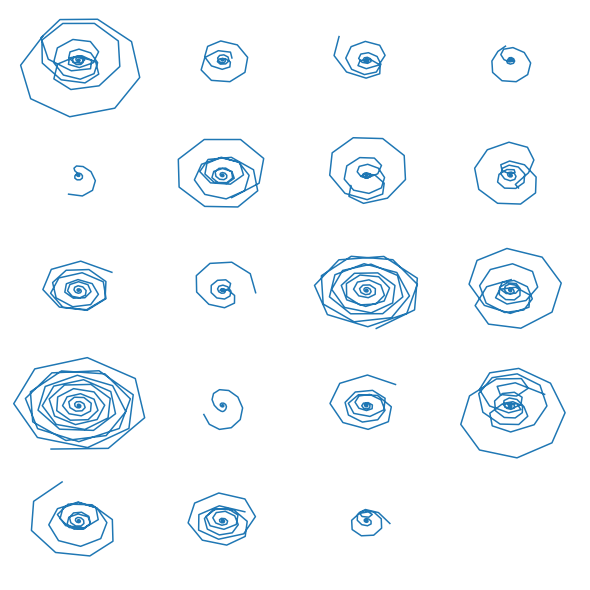

In [86]:
n_res = min(len(res),80)

n_row = int(np.ceil(np.sqrt(n_res)))
n_col = int(np.ceil(n_res/n_row))


fig, ax = plt.subplots(n_row, n_col, sharex=True, sharey=True, figsize=(8,8))
for i, res_i in enumerate(res):
    ax[i//n_col, np.mod(i,n_col)].plot(res_i['state'][:,1],res_i['state'][:,0])
    
for i in range(ax.size):
    ax[i//n_col, np.mod(i,n_col)].axis('off')

    
    
fig.tight_layout(pad=0)